In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import scipy
import torch

from math import ceil
from torch.autograd import Variable
from torch import nn
from torch.utils.data import DataLoader
from torch import optim

%matplotlib widget

In [3]:
with open('data.pkl', 'rb') as f:
    data = pickle.load(f)

### Define VAE

In [4]:
latent_dim = 2
batch_size = 32
num_epochs = 45

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self._cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout())
        
        self._nn = nn.Sequential(
            nn.Linear(1320, 512),
            nn.ReLU(),
            nn.Linear(512, 2*latent_dim))
        
    def forward(self, x):
#         x = x.reshape((-1, 256*205))
        x = self._cnn.forward(x)
        x = x.reshape(x.size(0), -1)
        x = torch.reshape(self._nn.forward(x), (-1, 2, self.latent_dim))
        mu, logvar = x[:,0,:], x[:,1,:]
        return mu, logvar, sample(mu, logvar) 

class Decoder(nn.Module):
    def __init__(self, latent_dim=latent_dim):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self._nn = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1320))
    
        self._cnn = nn.Sequential(
            nn.Upsample((67, 11)),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.Upsample((130, 18)),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3),
            nn.Upsample((256, 33)),
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=3))

    def forward(self,x):
        x = self._nn.forward(x)
        x = x.reshape(x.size(0),8,33,5)
        return self._cnn.forward(x)
    
def sample(mu, logvar):
    z = torch.randn_like(mu)
    return mu + torch.mul(torch.exp(0.5*logvar), z)

def vae_loss(x, x_hat, mu, logvar):
    mse = (x_hat - x).pow(2).sum()/(x.shape[0]*1.0)
    KL_loss = 0.5*torch.sum(-1 + torch.pow(mu,2) - logvar + torch.exp(logvar))/(x.shape[0]*1.0)
    return torch.add(mse, KL_loss)

def train(encoder, decoder, train_loader, optimizer, num_epochs = 30):  
    encoder.train()
    decoder.train()
    for i in range(num_epochs):
        print("Epoch {}".format(i))
        for j, x in enumerate(train_loader):
            _mu, _logvar, _z = encoder.forward(x)
            x_hat = decoder.forward(_z)
            optimizer.zero_grad()
            loss = vae_loss(x, x_hat, _mu, _logvar)
            loss.backward()
            optimizer.step()
            if j % 100 == 0:
                print(loss)            
    return loss

### Extract Spectrograms

In [7]:
def get_spectrograms(y, sr, n_fft=512, frame_size=0.2, overlap=0.5, hop_size=0.005, min_freq=0, max_freq=1024):
    dt = 1 / sr
    fr = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    max_freq_idx = np.argmin(np.abs(fr-max_freq))
    min_freq_idx = np.argmin(np.abs(fr-min_freq))
    T = (len(y)-1) * dt
    
    hop_length = round(hop_size / dt)
    N = round(T/frame_size)
    step_size = ceil(frame_size*(1-overlap)/dt)
    fsize = round(frame_size/dt)
    i = 0; idx = np.array([0, fsize], dtype=int)
    while idx[1]/sr < T:
        stft = librosa.stft(y[idx[0]:idx[1]], hop_length=hop_length, n_fft=n_fft)
        D = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
        yield [(D[min_freq_idx:max_freq_idx,:] + 100) / 100]
        idx += step_size

In [8]:
def compute_loss(specs):
    loss = []
    for s in specs:
        s = torch.tensor(np.array([s]))
        _mu, _logvar, _z = encoder.forward(s)
        x_hat = decoder.forward(_z)
        loss.append(float(vae_loss(s, x_hat, _mu, _logvar)))
    return np.array(loss)

### Test 1 - Hydrophone data only, using sensor 1 only

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


cases = list(data['hydrophone']['leak'].keys())
# cases = ['ndemand_ns']
specs_leak = []; specs = [];
y = data['hydrophone']['no_leak'][case][0]
specs = list(get_spectrograms(y, data['sr'], frame_size = 0.15, min_freq=10, max_freq=1024))
for case in cases:
    specs_leak += list(get_spectrograms(
                            data['hydrophone']['leak'][case][0], 
                            data['sr'], 
                            frame_size = 0.15,
                            min_freq=10,
                            max_freq=1024))

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle = True)
specs = np.array(specs)
specs_leak = np.array(specs_leak)

kf.get_n_splits(specs)
losses = np.zeros((n_splits, 3, 4))
all_losses_train = []; all_losses_test = []; all_losses_leak = []

for i, (train_index, test_index) in enumerate(kf.split(specs)):
    encoder = Encoder(latent_dim)
    decoder = Decoder(latent_dim)
    params = list(encoder.parameters())+list(decoder.parameters())
    optimizer = optim.Adam(params, lr=0.001)
    X = Variable(torch.Tensor(specs[train_index]))
    train_loader = DataLoader(X, batch_size=batch_size, drop_last = True)
    train(encoder, decoder, train_loader, optimizer, num_epochs = num_epochs)
    
    losses_train = compute_loss(specs[train_index])
    all_losses_train.append(losses_train)
    losses[i][0][0] = np.mean(losses_train)
    losses[i][0][1] = np.min(losses_train)
    losses[i][0][2] = np.max(losses_train)
    losses[i][0][3] = np.std(losses_train)
    
    losses_test = compute_loss(specs[test_index])
    all_losses_test.append(losses_test)
    losses[i][1][0] = np.mean(losses_test)
    losses[i][1][1] = np.min(losses_test)
    losses[i][1][2] = np.max(losses_test)
    losses[i][1][3] = np.std(losses_test)
    
    losses_leak = compute_loss(specs_leak)
    all_losses_leak.append(losses_leak)
    losses[i][2][0] = np.mean(losses_leak)
    losses[i][2][1] = np.min(losses_leak)
    losses[i][2][2] = np.max(losses_leak)
    losses[i][2][3] = np.std(losses_leak)
    
    print(losses[i,:,0])
    

Epoch 0
tensor(1455.3278, grad_fn=<AddBackward0>)
Epoch 1
tensor(191.6695, grad_fn=<AddBackward0>)
Epoch 2
tensor(83.4488, grad_fn=<AddBackward0>)
Epoch 3
tensor(72.2987, grad_fn=<AddBackward0>)
Epoch 4
tensor(57.0500, grad_fn=<AddBackward0>)
Epoch 5
tensor(47.6524, grad_fn=<AddBackward0>)
Epoch 6
tensor(46.1385, grad_fn=<AddBackward0>)
Epoch 7
tensor(43.1597, grad_fn=<AddBackward0>)
Epoch 8
tensor(43.2311, grad_fn=<AddBackward0>)
Epoch 9
tensor(42.0012, grad_fn=<AddBackward0>)
Epoch 10
tensor(43.0771, grad_fn=<AddBackward0>)
Epoch 11
tensor(43.0368, grad_fn=<AddBackward0>)
Epoch 12
tensor(41.4898, grad_fn=<AddBackward0>)
Epoch 13
tensor(41.7277, grad_fn=<AddBackward0>)
Epoch 14
tensor(41.2432, grad_fn=<AddBackward0>)
Epoch 15
tensor(41.5093, grad_fn=<AddBackward0>)
Epoch 16
tensor(40.8763, grad_fn=<AddBackward0>)
Epoch 17
tensor(41.1752, grad_fn=<AddBackward0>)
Epoch 18
tensor(40.9354, grad_fn=<AddBackward0>)
Epoch 19
tensor(39.5740, grad_fn=<AddBackward0>)
Epoch 20
tensor(40.5330, gr

In [16]:
specs.shape

(483, 1, 254, 31)

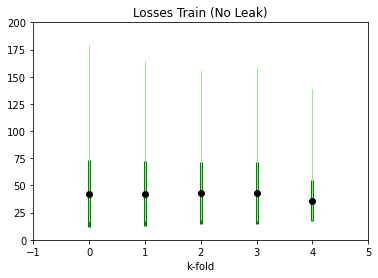

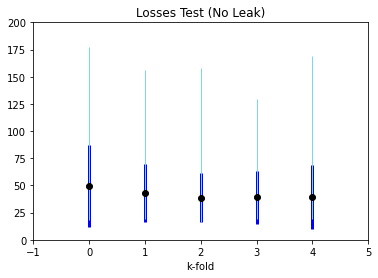

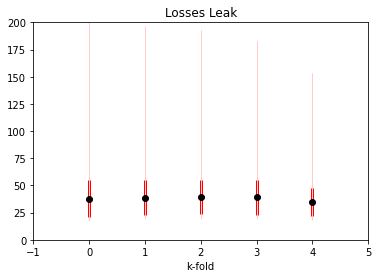

0.9741602067183462 0.9270833333333334 0.0050968399592252805


In [17]:
# threshold = 3
# print('true positive', np.mean(loss_leak > threshold), 'true negative', np.mean(loss_test < threshold))
# print('false positive', np.mean(loss_leak < threshold), 'false negative', np.mean(loss_test > threshold))
%matplotlib inline

titles = ['Losses Train (No Leak)', 'Losses Test (No Leak)', 'Losses Leak']
ecolors = [('green', '#90ee90'), ('blue', '#7AD7F0'), ('red', '#FFCCCB'),]
for i in range(len(titles)):
    loss_type = i
    loss_vals = losses[:,loss_type,:]
    means = loss_vals[:,0]; mins = loss_vals[:,1]; maxes = loss_vals[:,2]; std = loss_vals[:,3]
    plt.errorbar(np.arange(n_splits), means, std, fmt='ok', lw=3, ecolor=ecolors[i][0])
    plt.errorbar(np.arange(n_splits), means, [means - mins, maxes - means],
                 fmt='.k', ecolor=ecolors[i][1], lw=1)
    plt.xlim(-1, n_splits)
    plt.ylim(0, 200)
    plt.xlabel('k-fold')
    plt.title(titles[i])
    plt.savefig(f'{titles[i]}.png')
    plt.show()

i = 4 # split
j = 0 # train, test, leak 

loss_type = j
loss_vals = losses[:,loss_type,:]
means = loss_vals[:,0]; mins = loss_vals[:,1]; maxes = loss_vals[:,2]; std = loss_vals[:,3]

th = 100
print(np.mean(all_losses_train[i] < th),
np.mean(all_losses_test[i] < th),
np.mean(all_losses_leak[i] > th))
    


In [12]:
cases = list(data['hydrophone']['leak'].keys())
specs_leak = []; loss = []; loss1 = []
for case in cases:
    y = data['hydrophone']['leak'][case][0]
    specs_leak += list(get_spectrograms(y, data['sr'], frame_size = 0.15, min_freq=10, max_freq=1024))
specs_leak = np.array(specs_leak)[:,:,:,:]

cases = ['ndemand_ns']
specs_noleak = []; loss1 = []
for case in cases:
    y = data['hydrophone']['no_leak'][case][0]
    specs_noleak += list(get_spectrograms(y, data['sr'], frame_size = 0.15, min_freq=10, max_freq=1024))
specs_noleak = np.array(specs_noleak)[:,:,:,:]

for s in specs_leak:
    s = torch.tensor(np.array([s]))
    _mu, _logvar, _z = encoder.forward(s)
    x_hat = decoder.forward(_z)
    loss.append(float(vae_loss(s, x_hat, _mu, _logvar)))

for s in specs_noleak:
    s = torch.tensor(np.array([s]))
    _mu, _logvar, _z = encoder.forward(s)
    x_hat = decoder.forward(_z)
    loss1.append(float(vae_loss(s, x_hat, _mu, _logvar)))

In [ ]:
import pandas as pd

loss = np.array(loss)
x = pd.DataFrame(zip(loss, loss1), columns=['leak', 'no_leak'])
np.mean(x.leak > np.mean(x.no_leak))


In [ ]:
D = specs[3]
fig, ax = plt.subplots(nrows=1, ncols=1)
img = librosa.display.specshow(D, y_axis='log', sr=sr, hop_length=hop_length,
                     x_axis='time', ax=ax)
ax.set(title='Log-frequency power spectrogram')
ax.label_outer()
fig.colorbar(img, ax=ax, format="%+2.f dB")
D.shape, sr, len(y), frame_size, dt
    